<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [2]:
import os

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Tensor operations
import tensorflow as tf
import keras.backend as K

# Neural Network
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense, Activation
from keras.optimizers import Adam

# Data processing & Cross-validation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

# Stats
from scipy.stats import linregress, kendalltau
from sklearn.metrics import mean_absolute_error

# Visualization
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(0)

Using TensorFlow backend.


### Neural Network

A simple Fully Connected Neural Network

In [0]:
# GPU info
# !nvidia-smi

In [0]:
# load features dataset
filepath = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_features_final.csv"
datasets = pd.read_csv(filepath)

# rename
datasets.rename(columns={'SAU Gyr IC50 (礛)':'pIC50'}, inplace=True)

pattern = "[<]"
filters = datasets.pIC50.str.contains(pattern)
datasets["left_saturated"] = filters

pattern = "[>]"
filters = datasets.pIC50.str.contains(pattern)
datasets["right_saturated"] = filters

# Reorder dataframe
cols = datasets.columns.tolist()
cols = cols[:2] + cols[-2:] + cols[3:-2]
datasets = datasets[cols]

datasets['pIC50'] = datasets['pIC50'].str.replace(r'[><]', '')
datasets['pIC50'] = datasets['pIC50'].apply(lambda x: np.log(float(x)))

# drop Ipc
datasets = datasets.drop(['Ipc'], axis=1)

Select __X__ and __Y__ vectors.

In [0]:
# input and output
y = datasets['pIC50'].copy()
y = y.astype('float64').to_numpy()

x = datasets.iloc[:,5:].copy()
x = x.astype('float64').to_numpy()

# qualifiers classification
s1 = datasets['left_saturated' ].apply(lambda x: x*1).copy()
s2 = datasets['right_saturated'].apply(lambda x: x*1).copy()

s1 = s1.to_numpy()
s2 = s2.to_numpy()

s0 = s1 + s2

# > greater
rcutoff = s2 * datasets['pIC50'].copy().astype('float64')
rcutoff = rcutoff.to_numpy()

# < lower
lcutoff = s1 * datasets['pIC50'].copy().astype('float64')
lcutoff = lcutoff.to_numpy()

In [6]:
datasets.head(5)

,Molecule SMILES,pIC50,left_saturated,right_saturated,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,BalabanJ,BertzCT,HallKierAlpha,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,...,f_3821,f_3831,f_3838,f_3839,f_3850,f_3864,f_3873,f_3888,f_3896,f_3897,f_3907,f_3914,f_3921,f_3924,f_3940,f_3945,f_3959,f_3963,f_3976,f_3980,f_3992,f_3994,f_4003,f_4006,f_4009,f_4013,f_4015,f_4026,f_4028,f_4033,f_4034,f_4039,f_4044,f_4048,f_4057,f_4062,f_4069,f_4076,f_4090,f_4095
0,c1cc(c(nc1)N2CCC(CC2)NC(=O)c3cc(c([nH]3)Cl)Cl)...,5.991465,False,True,-0.435597,0.013283,0.623001,384.223,0.311075,-0.350740,1.400000,2.120000,1.606288,782.714558,-2.32,3.853433,15.200677,10.847038,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,23.201880,24.974377,31.394564,9.945944,9.717848,40.614309,15.284746,0.0,18.883484,17.989423,50.379934,0.000000,10.216698,11.505249,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CC(C)c1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)[N...,3.912023,False,True,-0.411106,0.011515,0.550709,436.310,0.311075,-0.353241,1.444444,2.148148,1.607439,843.272683,-2.42,4.292290,15.200677,5.693928,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,13.847474,46.822227,41.561212,4.923311,9.717848,33.342373,15.284746,0.0,38.648865,17.989423,50.370839,0.000000,10.216698,11.505249,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CCOC(=O)c1cc(nc(c1C#N)N2CCC(CC2)NC(=O)c3cc(c([...,1.965713,False,False,-0.518193,0.024077,0.644188,474.359,0.339176,-0.462356,1.366667,2.066667,1.707098,983.301265,-2.86,4.648309,19.937540,23.144464,0.0,0.000000,5.90718,5.969305,4.794537,9.778516,5.261892,0.0,0.000000,61.675533,34.991929,12.170333,14.325937,33.624292,15.284746,0.0,39.654696,24.596305,44.814141,6.069221,10.216698,5.817863,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)C#N)Br,2.295560,False,False,-0.085370,0.085370,0.847033,388.269,0.267458,-0.355369,1.500000,2.250000,1.591350,767.018857,-2.33,3.436063,15.200677,17.581012,0.0,0.000000,5.90718,0.000000,4.794537,4.983979,5.261892,0.0,0.000000,53.894426,35.494845,5.563451,4.794537,27.654986,15.284746,0.0,25.807221,17.989423,45.819972,6.069221,10.216698,5.817863,...,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3ccc4ccccc4n3)Br,1.196948,False,False,-0.040667,0.040667,0.681761,413.319,0.267458,-0.356445,1.230769,2.000000,1.376538,924.389107,-2.34,3.464258,15.200677,11.511791,0.0,0.000000,5.90718,0.000000,4.794537,4.983979,0.000000,0.0,18.199101,59.960793,34.684225,5.516701,4.794537,38.557911,15.284746,0.0,25.807221,17.989423,58.325145,0.000000,10.216698,5.817863,...,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Split the machine-learning-ready dataset into __training__, __test__ and __validation__ subsets.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.75, random_state=42)

The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data, neural networks mostly. Here we will normalize the features and $\log{\text{IC50}}$ to have zero-mean and unit-standard-deviation.

In [8]:
# input dimensions
number_of_features = x.shape[1]

# Start neural network
network = Sequential()

# Input layer with a ReLU activation function
network.add(Dense(units=50, input_shape=(number_of_features, )))
network.add(BatchNormalization())
network.add(Activation("relu"))
network.add(Dropout(0.2))

# Add fully connected layer with a ReLU activation function
network.add(Dense(units=100))
network.add(Activation("relu"))
network.add(Dropout(0.2))

# Add fully connected layer with a ReLU activation function
network.add(Dense(units=100))
network.add(Activation("relu"))

# Add fully connected layer with a ReLU activation function
network.add(Dense(units=25))
network.add(Activation("relu"))

# Add fully connected layer with a sigmoid activation function
network.add(Dense(units=1, activation='linear'))

W0821 01:41:33.387454 140064132368256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 01:41:33.409793 140064132368256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 01:41:33.413895 140064132368256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 01:41:33.528400 140064132368256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0821 01:41:33.577072 

The customized Loss function.

In [0]:
def custom_loss(y_true, y_pred):
    # get deltas
    z = y_pred - y_true
    r = y_pred - rcutoff
    l = y_pred - lcutoff
    # qualifiers adjusted Loss function
    #return K.mean((1-s0)*K.square(z), axis=-1)
    return K.mean((1-s0)*K.square(z) + s2*K.relu(-r) + s1*K.relu(l), axis=-1)

### Run Lola, Run

Parameters are not optimized!!!

In [10]:
# Compile neural network
network.compile(loss=custom_loss,                     # Custom loss function
                optimizer=Adam(lr=1e-2, decay=1e-4),  # Adam optimizer
                metrics=['mse'])                      # Accuracy performance metric

W0821 01:41:33.767615 140064132368256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [11]:
# Train neural network
history = network.fit(x_train,                          # Features
                      y_train,                          # Target
                      epochs=500,                       # Number of epochs
                      verbose=0,                        # No output
                      batch_size=50,                    # Number of observations per batch
                      validation_data=(x_test, y_test)) # Data for evaluation

W0821 01:41:34.283936 140064132368256 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



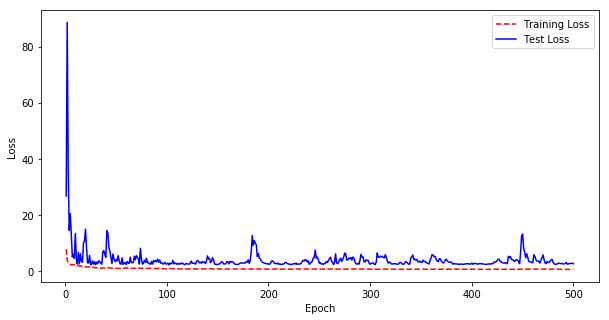

In [12]:
plt.rcParams["figure.figsize"] = (10,5)    # plot size

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

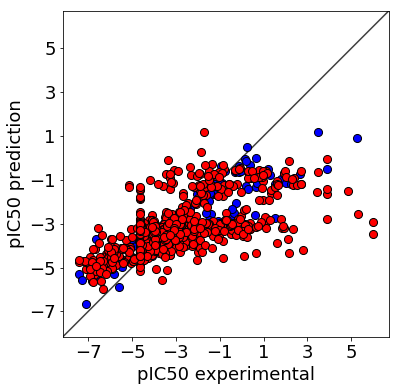

In [13]:
plt.rcParams["figure.figsize"] = (18,6)    # plot size
fig, ax = plt.subplots()

c = 'blue'
ax.scatter(y_train, network.predict(x_train), 
           s=65, c=c, zorder=10, edgecolors='k')

#c = y_test.astype(int)
c = 'red'
ax.scatter(y_test, network.predict(x_test), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=18)
ax.set_ylabel("pIC50 prediction",   fontsize=18)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.show()

In [14]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.6282707343631376
MAE         : 1.2702362598725763
Kendall Tau : 0.5114571329078598


### Cross-validation

In [15]:
kf = KFold(n_splits=4, random_state=None, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    history = network.fit(x_train, y_train, epochs=100, verbose=0, batch_size=10, validation_data=(x_test, y_test))
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, network.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, network.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, network.predict(x_test)[:,0])
    
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

R2          : 0.7931694207022714
MAE         : 1.0659664352628002
Kendall Tau : 0.6281985468223853
R2          : 0.8657537235472365
MAE         : 0.7765913352579891
Kendall Tau : 0.7123394791657267
R2          : 0.8826400888310311
MAE         : 0.6877943092518017
Kendall Tau : 0.7165547562354033
R2          : 0.8730907617974484
MAE         : 0.7573520859368338
Kendall Tau : 0.719174514036722


### Shallow (A Star Is Born)

In [0]:
# Start linear network
shallow = Sequential()

# A single fully connected layer
shallow.add(Dense(units=1, input_shape=(number_of_features, )))
shallow.add(BatchNormalization())
shallow.add(Activation("linear"))

In [0]:
# Compile shallow linear regression
shallow.compile(loss=custom_loss,                     # Custom loss function
                optimizer=Adam(lr=1e-2, decay=1e-4),  # Adam optimizer
                metrics=['mse'])                      # Accuracy performance metric

# Train shallow model
historia = shallow.fit(x_train,                          # Features
                       y_train,                          # Target
                       epochs=500,                       # Number of epochs
                       verbose=0,                        # No output
                       validation_data=(x_test, y_test)) # Data for evaluation

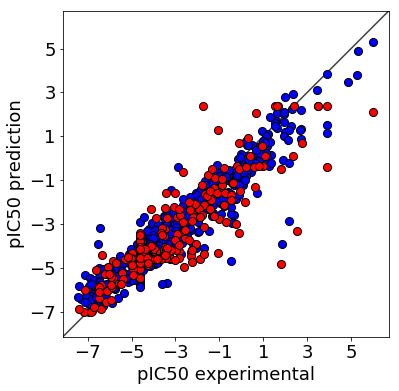

In [18]:
fig, ax = plt.subplots()

c = 'blue'
ax.scatter(y_train, shallow.predict(x_train), 
           s=65, c=c, zorder=10, edgecolors='k')

c = 'red'
ax.scatter(y_test, network.predict(x_test), 
           s=65, c=c, cmap=plt.cm.coolwarm, 
           zorder=10, edgecolors='k')

ax.set_xlabel("pIC50 experimental", fontsize=18)
ax.set_ylabel("pIC50 prediction",   fontsize=18)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# integer limits
ilims = [int(x+0.5) for x in lims]
ax.set_xticks(np.arange(*ilims,2))
ax.set_yticks(np.arange(*ilims,2))

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.show()

In [19]:
slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])

print("R2          : %s" % r_value)
print("MAE         : %s" % mae)
print("Kendall Tau : %s" % tau)

R2          : 0.7783393988939317
MAE         : 1.072365809936999
Kendall Tau : 0.6100375388259397


In [20]:
kf = KFold(n_splits=4, random_state=None, shuffle=True)

for train_index, test_index in kf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    history = shallow.fit(x_train, y_train, epochs=100, verbose=0, batch_size=10, validation_data=(x_test, y_test))
    
    slope, intercept, r_value, p_value, std_err = linregress(y_test, shallow.predict(x_test)[:,0])
    tau, p_value                                = kendalltau(y_test, shallow.predict(x_test)[:,0])
    mae                                         = mean_absolute_error(y_test, shallow.predict(x_test)[:,0])
    
    print("R2          : %s" % r_value)
    print("MAE         : %s" % mae)
    print("Kendall Tau : %s" % tau)

R2          : 0.8717153564247303
MAE         : 0.9089972258627822
Kendall Tau : 0.6804044422079162
R2          : 0.8976221913737661
MAE         : 0.8766582777746913
Kendall Tau : 0.6897889975394321
R2          : 0.8776203471989351
MAE         : 1.0271497206120535
Kendall Tau : 0.7253263976054591
R2          : 0.8609807170759285
MAE         : 2.8345484727448746
Kendall Tau : 0.7150028290070874
